GDCV 04 이미지 어디까지 우려볼까?

프로젝트: CutMix 또는 Mixup 비교실험 하기

<<목차>>


1) Augmentation을 적용한 데이터셋 만들기

2) 모델 만들기

3) 모델 훈련하기

4) 훈련 과정 시각화하기

5) Augmentation에 의한 모델 성능 비교

6) 루브릭

7) 회고

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

2022-12-02 13:57:21.242396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 13:57:21.551078: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-02 13:57:22.647383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.0/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.7/lib64
2022-12-02 13:57:22.647522: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

In [2]:
tf.config.list_physical_devices('GPU')

2022-12-02 13:57:38.788718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 13:57:38.836533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 13:57:38.836793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

1. Augmentation을 적용한 데이터셋 만들기

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

2022-12-02 13:57:52.523304: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /home/june/tensorflow_datasets/stanford_dogs/0.2.0.incomplete9N40ZL/stanford_dogs-train.tfrecord*...…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /home/june/tensorflow_datasets/stanford_dogs/0.2.0.incomplete9N40ZL/stanford_dogs-test.tfrecord*...:…

Dataset stanford_dogs downloaded and prepared to /home/june/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


2022-12-02 13:59:14.210922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 13:59:14.211935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 13:59:14.212245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 13:59:14.212411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))  # tf.Tensor(18610, shape=(), dtype=int64)
print(tf.data.experimental.cardinality(ds_test))  # tf.Tensor(4652, shape=(), dtype=int64)

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


In [6]:
NUM_CLASSES = ds_info.features["label"].num_classes
NUM_CLASSES  # 120

120

In [7]:
ds_info.features["label"].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

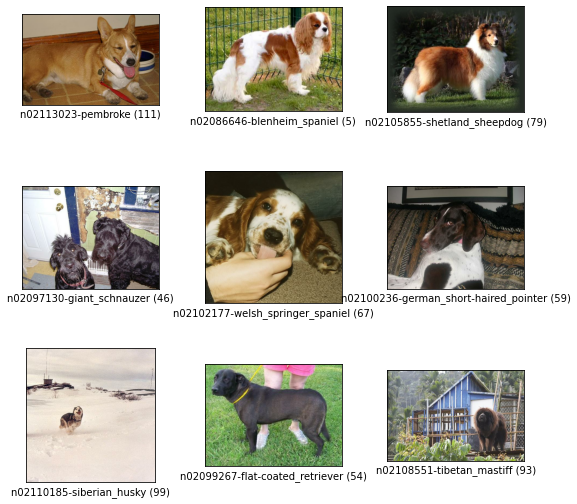

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

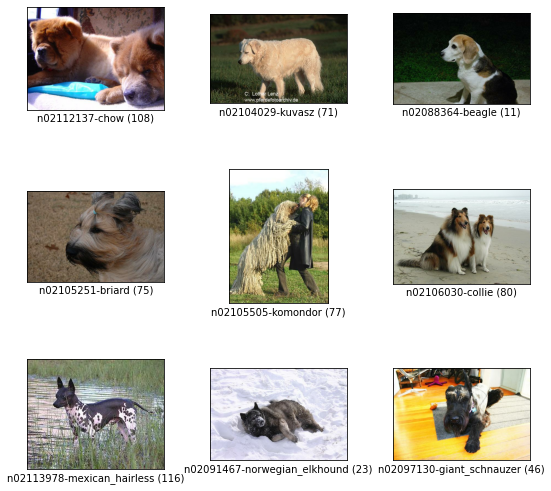

In [9]:
fig = tfds.show_examples(ds_test, ds_info)

In [10]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [11]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [12]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [13]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [14]:
# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [15]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [16]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [17]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [18]:
def onehot(image, label, num_classes=120):
    label_one_hot = tf.one_hot(label, num_classes)
    return image, label_one_hot

In [19]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,  # normalizing 과 resizing 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment  # augment 함수 적용
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,  # cutmix augment 함수 적용
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,  # mixup augment 함수 적용
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,  # one - hot encoding
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [20]:
# BATCH_SIZE = 16

strategy = tf.distribute.MirroredStrategy()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [21]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=BATCH_SIZE)

In [22]:
# 데이터셋에서 이미지 가져와서 시각화
def draw_ds_train(ds_train, batch_size=16, row=6, col=4):
    row = min(row, batch_size//col)  # row 재설정
    
    # 데이터셋에서 배치 사이즈(=16개)만큼 1번만 이미지 가져오기
    for i, (image, label) in enumerate(ds_train.take(1)):
        
        plt.figure(figsize=(8,int(8*row/col)))  # 8x8 크기
        for j in range(row*col):
            plt.subplot(row,col,j+1)
            plt.axis('off')
            plt.imshow(image[j,])  # 가져온 이미지(16개) 하나씩 출력
                    
        plt.tight_layout()
        plt.show()

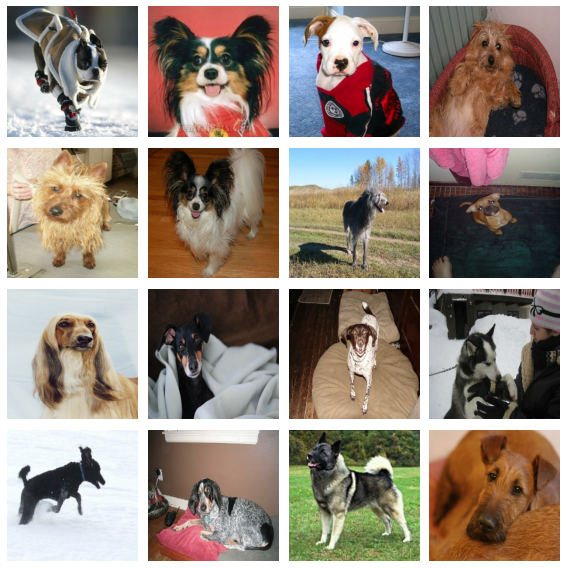

In [23]:
draw_ds_train(ds_train_no_aug, BATCH_SIZE)

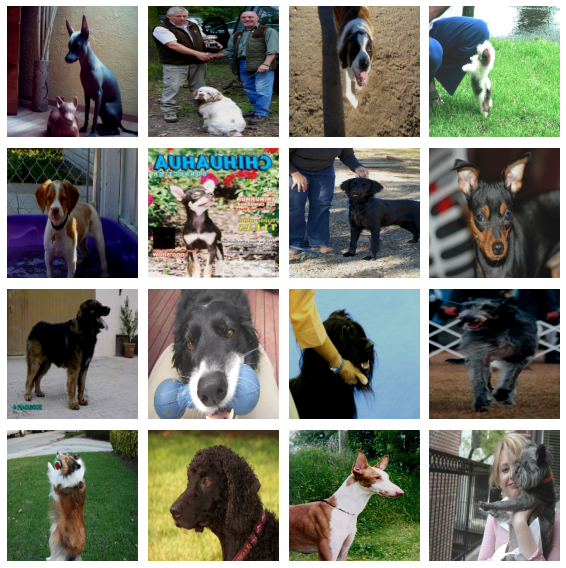

In [24]:
draw_ds_train(ds_train_aug, BATCH_SIZE)

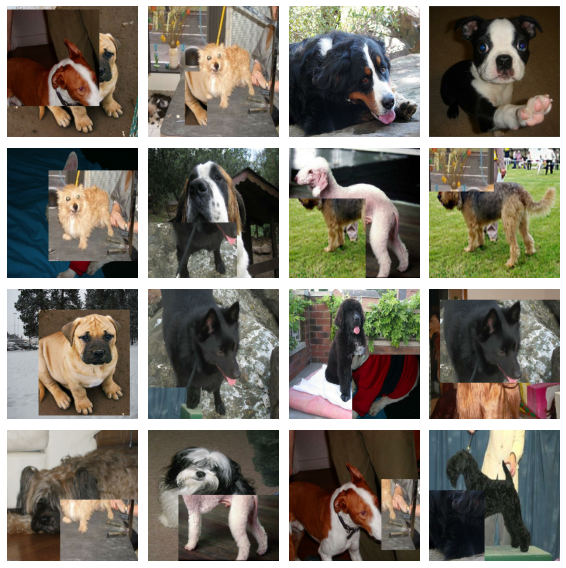

In [25]:
draw_ds_train(ds_train_aug_cutmix, BATCH_SIZE)

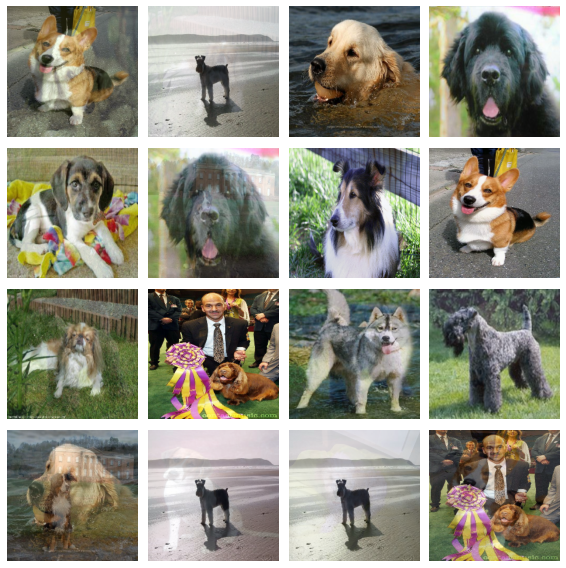

In [26]:
draw_ds_train(ds_train_aug_mixup, BATCH_SIZE)

2) 모델 만들기

In [27]:
def create_ResNet50(include_top=False,
                    weights='imagenet',
                    input_shape=(224,224,3),
                    pooling='avg',
                    num_classes=120,
                    activation='softmax'):
                    
    resnet50 = keras.models.Sequential([
        keras.applications.resnet.ResNet50(
            include_top=include_top,
            weights=weights,
            input_shape=input_shape,
            pooling=pooling,
        ),
        keras.layers.Dense(num_classes, activation=activation)
    ])
    return resnet50

In [28]:
resnet50_no_aug = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_no_aug 으로 학습시킬 ResNet
resnet50_aug = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_aug 으로 학습시킬 ResNet
resnet50_aug_cutmix = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_aug_cutmix 으로 학습시킬 ResNet
resnet50_aug_mixup = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_aug_mixup 으로 학습시킬 ResNet

94765736/94765736 [==============================] - 5s 0us/step


3) 모델 훈련하기

In [29]:
EPOCH = 30

LEARNING_RATE = 0.01

Learning rate schedule: 0.001 to 0.05 to 0.000336


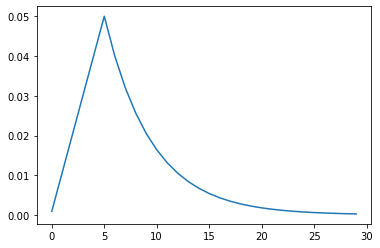

In [30]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.001  # 0.00001
LR_MAX = 0.05 * strategy.num_replicas_in_sync  # 0.00005
LR_MIN = 0.0001  # 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCH<25 else EPOCH)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [31]:
def compile_and_fit(resnet50,
                    ds_train,
                    ds_test,
                    ds_info,
                    learning_rate=0.01,
                    batch_size=16,
                    epochs=3):
                    
    resnet50.compile(
        loss='categorical_crossentropy',
        optimizer='sgd',
        metrics=['accuracy'],
    )

    history_resnet50 = resnet50.fit(
        ds_train, # augmentation 적용하지 않은 데이터셋 사용
        steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
        epochs=epochs,
        callbacks=[lr_callback],
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history_resnet50

In [32]:
history_resnet50_no_aug = compile_and_fit(
    resnet50_no_aug,
    ds_train_no_aug,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30


2022-12-02 14:03:35.942424: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-12-02 14:03:37.042456: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


750/750 [==============================] - ETA: 0s - loss: 4.4934 - accuracy: 0.0677

2022-12-02 14:05:19.009311: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23970816 exceeds 10% of free system memory.
2022-12-02 14:05:23.010420: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23970816 exceeds 10% of free system memory.


750/750 [==============================] - 114s 143ms/step - loss: 4.4934 - accuracy: 0.0677 - val_loss: 4.5888 - val_accuracy: 0.0569 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/30
391/750 [==============>...............] - ETA: 43s - loss: 2.1928 - accuracy: 0.4377

In [ ]:
history_resnet50_aug = compile_and_fit(
    resnet50_aug,
    ds_train_aug,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)

In [ ]:
history_resnet50_aug_cutmix = compile_and_fit(
    resnet50_aug_cutmix,
    ds_train_aug_cutmix,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)

In [ ]:
history_resnet50_aug_mixup = compile_and_fit(
    resnet50_aug_mixup,
    ds_train_aug_mixup,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)

4) 훈련 과정 시각화하기

In [ ]:
plt.subplots(figsize=(15,15))

# No Aug, With Aug, With CutMix, With Mixup 의 Training Loss 시각화
plt.subplot(411)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'y')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'g')
plt.title('ResNet50 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Training Accuracy 시각화
plt.subplot(412)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['accuracy'], 'g')
plt.title('ResNet50 Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Validation Loss 시각화
plt.subplot(413)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'g')
plt.title('ResNet50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Validation Accuracy 시각화
plt.subplot(414)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

plt.tight_layout()
plt.savefig('result/Results_With_all_Aug.png')  # 저장
plt.show()

In [ ]:
plt.subplots(figsize=(15,8))

# No Aug, With Aug, With CutMix, With Mixup Validation Accuracy 시각화
plt.subplot(211)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup Validation Accuracy 시각화 2
plt.subplot(212)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 

plt.tight_layout()
plt.savefig('result/Validation_Accuracy_With_Aug.png')  # 저장
plt.show()

5) Augmentation에 의한 모델 성능 비교

In [ ]:
def get_df_resnet50_result(col='val_accuracy'):
    # ResNet50 (No Aug, With Aug, With CutMix, With Mixup) 학습 결과 저장
    resnet50 = {
        'No Aug': history_resnet50_no_aug.history[col],
        'With Aug': history_resnet50_aug.history[col],
        'With CutMix': history_resnet50_aug_cutmix.history[col],
        'With Mixup': history_resnet50_aug_mixup.history[col]
    }

    # 데이터 프레임으로 생성
    df_resnet50 = pd.DataFrame(resnet50, index=[f'EPOCHS_{i}' for i in range(EPOCH)])
    return df_resnet50

In [ ]:
df_resnet50_loss = get_df_resnet50_result('loss')
df_resnet50_loss

In [ ]:
df_resnet50_acc = get_df_resnet50_result('accuracy')
df_resnet50_acc

In [ ]:
df_resnet50_val_loss = get_df_resnet50_result('val_loss')
df_resnet50_val_loss

In [ ]:
df_resnet50_val_acc = get_df_resnet50_result('val_accuracy')
df_resnet50_val_acc

In [ ]:
# ResNet50 (No Aug, With Aug, With CutMix, With Mixup) 학습 결과 평균값을 딕셔너리로 저장
resnet50_result = {
    'loss': round(df_resnet50_loss.mean(),2),
    'accuracy': round(df_resnet50_acc.mean(),2),
    'val_losss': round(df_resnet50_val_loss.mean(),2),
    'val_accuracy': round(df_resnet50_val_acc.mean(),2),
}

# 데이터 프레임 생성
df_resnet50_result = pd.DataFrame(resnet50_result)
df_resnet50_result

In [ ]:
df_resnet50_result['val_accuracy']

In [ ]:
df_resnet50_result

6) 루브릭

1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?

CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.


2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?

각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음


3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?

기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

7) 회고

- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**